This notebook produces a combined ROC figure for both the abrupt and gradual regime transition examples associated with this folder.

In [1]:
import warnings
import pickle
from tqdm import tqdm
from collections import OrderedDict

import pyleoclim as pyleo
import numpy as np
import ammonyte as amt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde

### Load ODP record

In [2]:
#Defining group lists for easy loading
group_names = ['ODP 925'] #,'ODP 927','ODP 929','ODP 846','ODP 849']

Time axis values sorted in ascending order


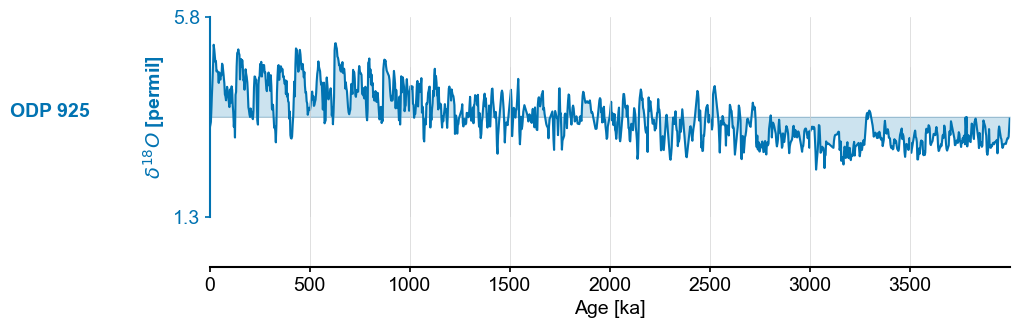

In [3]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('./data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,2*len(ms.series_list)))

### Load NGRIP record

In [4]:
end_time=10000

NGRIP_lipd = pyleo.Lipd('./data/8k_ice/NGRIP.NGRIP.2004.lpd')
NGRIP_tso = NGRIP_lipd.to_LipdSeriesList()
NGRIP_series = NGRIP_tso[0].slice((0,end_time))
NGRIP_series.time_unit = 'ka'

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: NGRIP.NGRIP.2004.lpd
Finished read: 1 record
extracting paleoData...
extracting: NGRIP.NGRIP.2004
Created time series: 3 entries
Both age and year information are available, using age
Both age and year information are available, using age
Both age and year information are available, using age


/var/folders/5k/0y4jsz592qq0y78c_0ddgcpm0000gn/T/ipykernel_19266/2600103537.py:3: DeprecationWarning: The Lipd class is being deprecated and will be removed in Pyleoclim v1.0.0. Functionalities will instead be handled by the pyLipd package.
  NGRIP_lipd = pyleo.Lipd('./data/8k_ice/NGRIP.NGRIP.2004.lpd')


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='d18O [permil]'>)

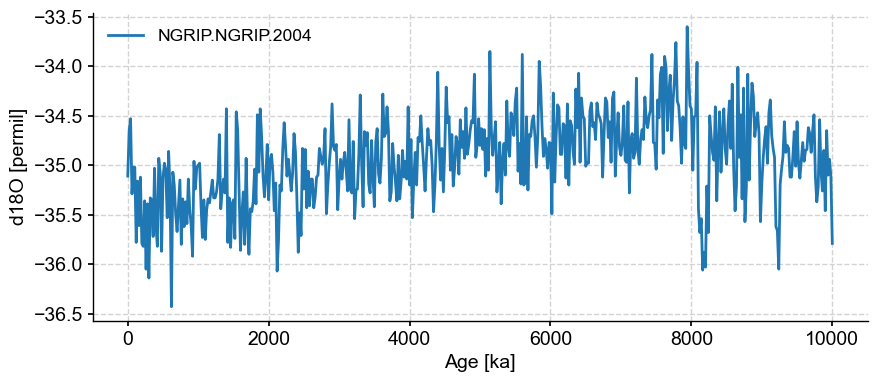

In [5]:
NGRIP_series.plot()

### Defining functions

In [6]:
def ROC_curve_lp(transition_hist,window=[800,1000],num_points=10000):
    """Function to calculate tpr and fpr
    
    Parameters
    ----------
    
    transition_hist : np.array
        Array of transition timings
        
    num_points : int
        Number of points to use for the kde time axis
        
    Returns
    -------
    
    tpr : float
        True positive rate
        
    fpr : float
        False positive rate
    """
    kde = gaussian_kde(transition_hist,bw_method=.06)
    x_axis = np.linspace(transition_hist.min(),transition_hist.max(),num_points)
    evaluated = kde.evaluate(x_axis)
    evaluated /= max(evaluated) #Normalize the kde
    thresholds = np.linspace(1,0,30)
    maxima = find_peaks(evaluated)[0]
            
    tpr = [0]
    fpr = [0]
    
    for threshold in thresholds:
        tp=0
        tn=0
        fp=0
        fn=0
        for i in range(len(x_axis)):
            time = x_axis[i]
            amplitude = evaluated[i]
            if time <= window[-1] and time >= window[0]:
                if amplitude < threshold:
                    fn+=1
                elif amplitude >= threshold:
                    tp+=1

            elif (time >= window[-1] or time <= window[0]):
                if amplitude < threshold:
                    tn+=1
                elif amplitude >= threshold:
                    fp+=1
        
        if tp+fn > 0:
            tpr.append(tp/(tp+fn))
        else:
            tpr.append(0)
            
        if fp+tn > 0:
            fpr.append(fp/(fp+tn))
        else:
            fpr.append(0)
            
    return tpr, fpr

def ROC_curve_8k(transition_hist,window=[[7400,7600],[9000,9200]],num_points=10000):
    """Function to calculate tpr and fpr
    
    Parameters
    ----------
    
    transition_hist : np.array
        Array of transition timings
        
    Returns
    -------
    
    tpr : float
        True positive rate
        
    fpr : float
        False positive rate
    """
    kde = gaussian_kde(transition_hist,bw_method=.05)
    x_axis = np.linspace(transition_hist.min(),transition_hist.max(),num_points)
    evaluated = kde.evaluate(x_axis)
    evaluated /= max(evaluated)
    thresholds = np.linspace(1,0,30)
    maxima = find_peaks(evaluated)[0]
            
    tpr = [0]
    fpr = [0]
    
    for threshold in thresholds:
        tp=0
        tn=0
        fp=0
        fn=0
        for i in range(len(x_axis)):
            time = x_axis[i]
            amplitude = evaluated[i]
            if (time <= window[0][-1] and time >= window[0][0]) or (time <= window[1][-1] and time >= window[1][0]):
                if amplitude < threshold:
                    fn+=1
                elif amplitude >= threshold:
                    tp+=1
            elif (time < window[0][0] or time > window[1][-1]) or (time < window[1][0] and time > window[0][-1]):
                if amplitude < threshold:
                    tn += 1
                elif amplitude >= threshold:
                    fp += 1
        if tp+fn > 0:
            tpr.append(tp/(tp+fn))
        else:
            tpr.append(0)
            
        if fp+tn > 0:
            fpr.append(fp/(fp+tn))
        else:
            fpr.append(0)
            
    return tpr, fpr

### Plotting

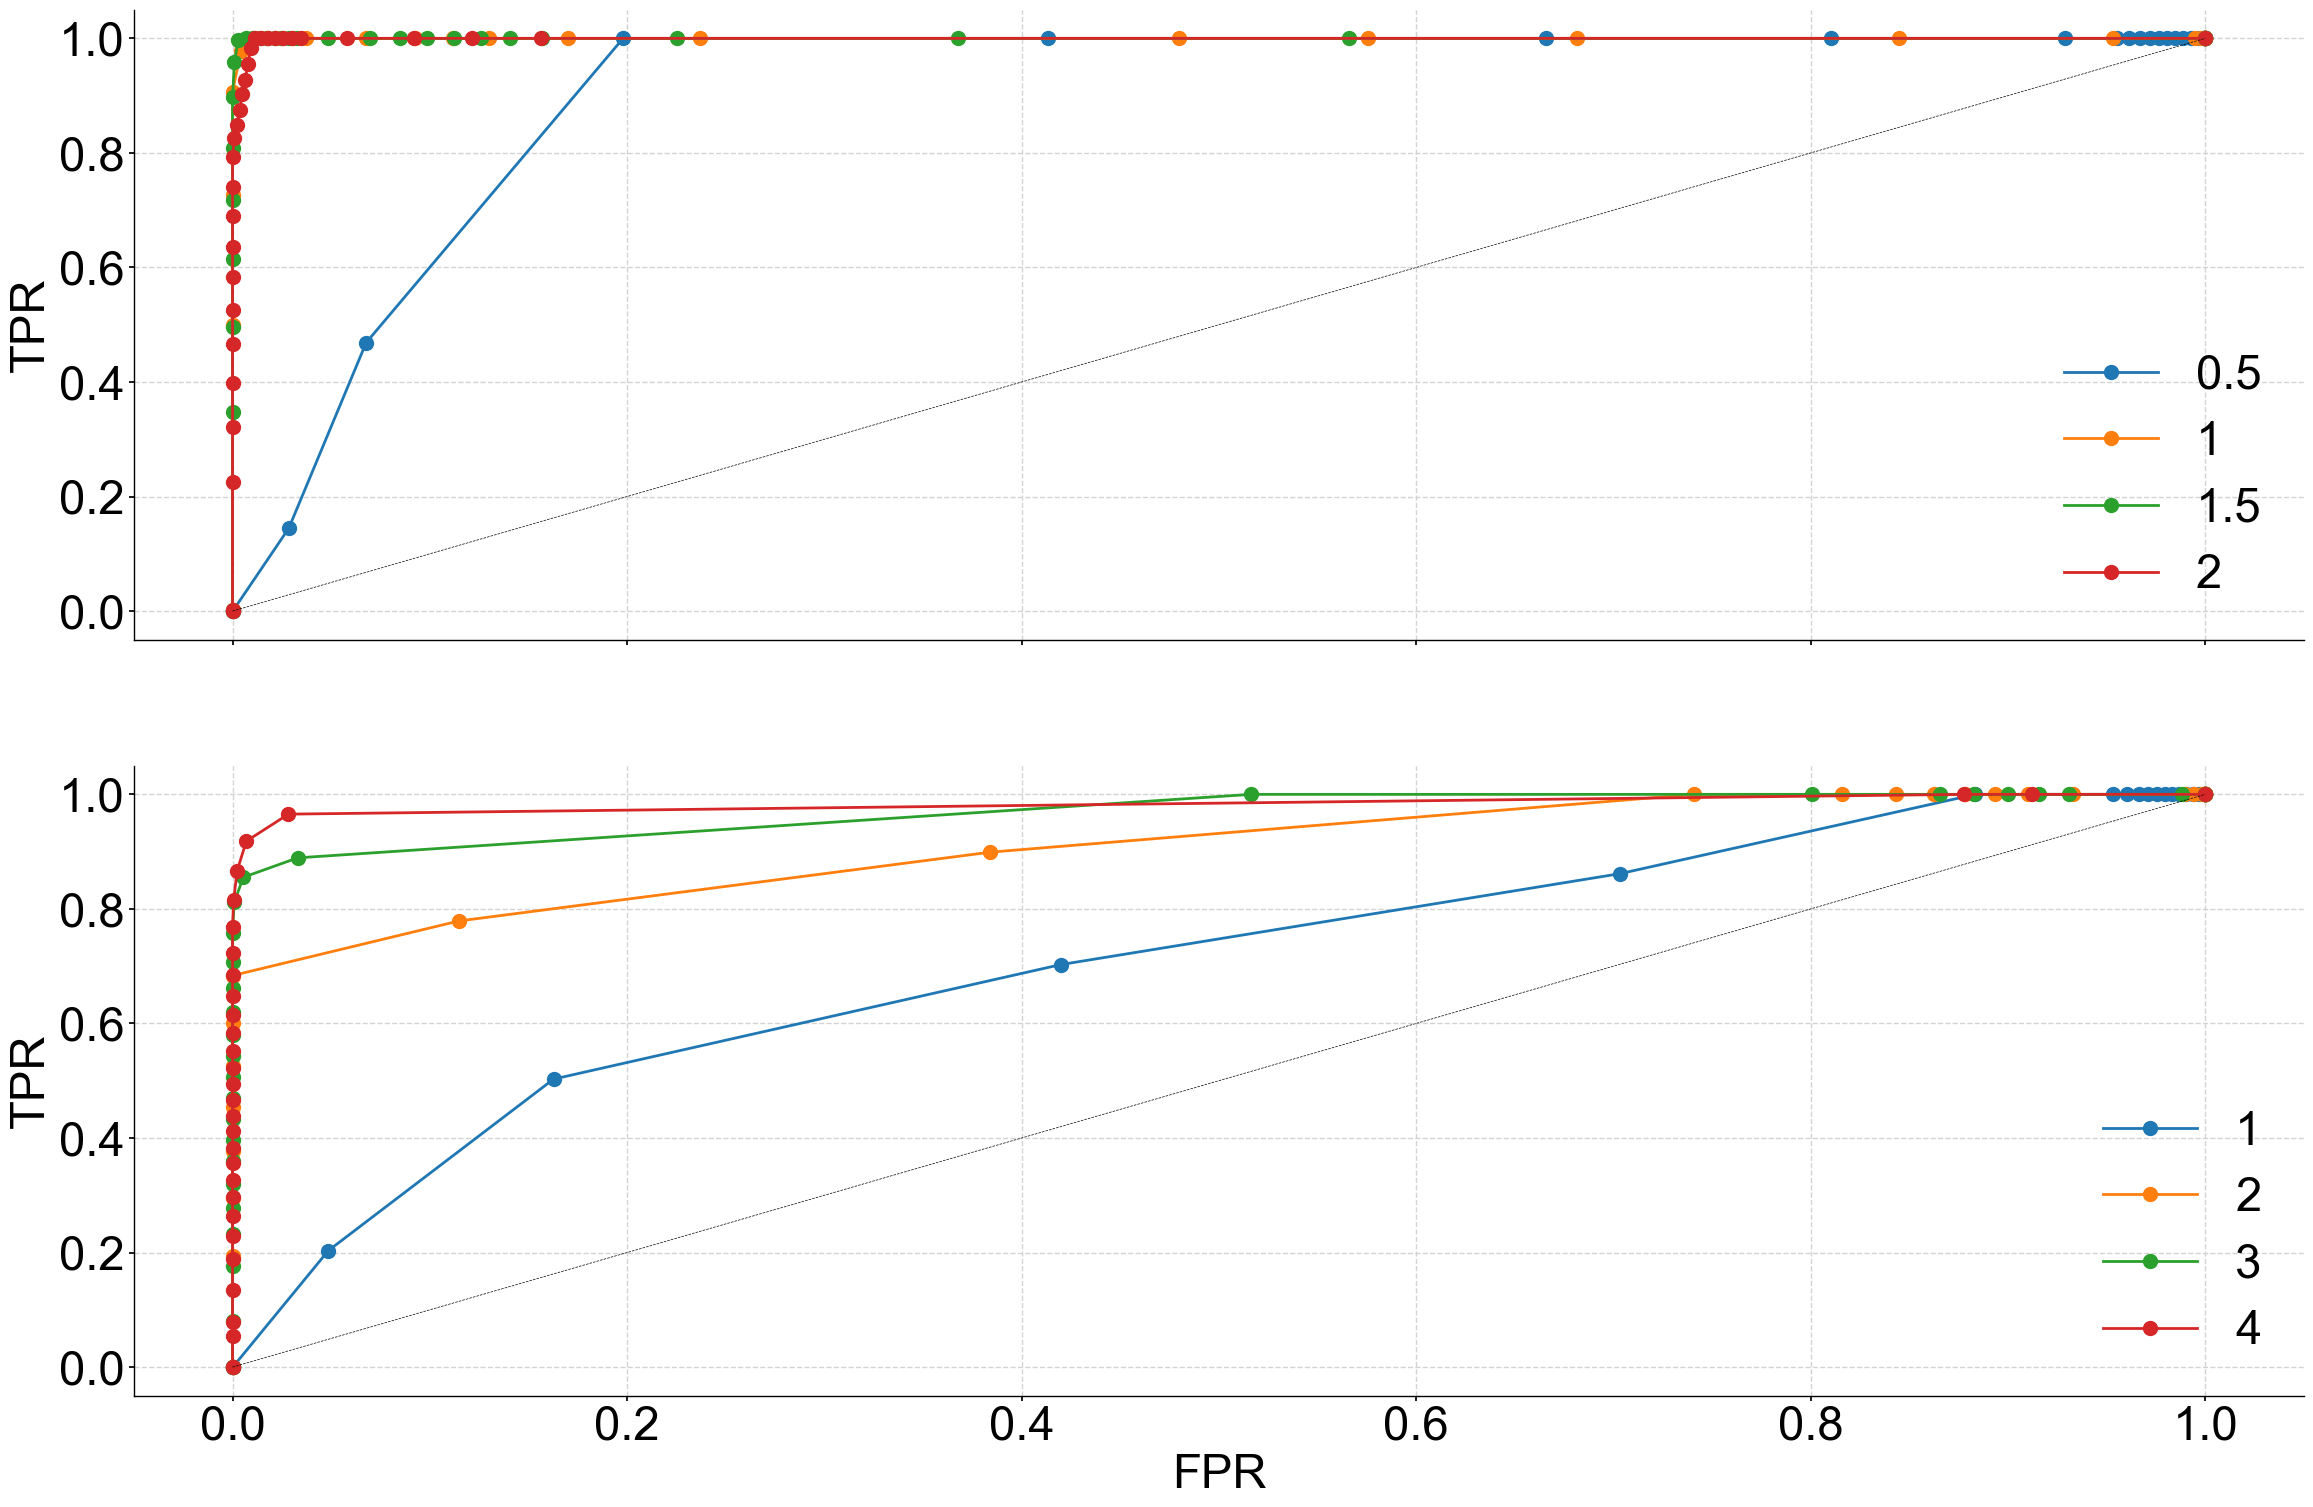

In [7]:
#Production figure

SMALL_SIZE = 34
MEDIUM_SIZE = 34
BIGGER_SIZE = 34

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,ax = plt.subplots(figsize=(28,18),nrows=2,sharex=True)
axes = ax.ravel()

with open('./data/leloup_paillard_transitions.pkl','rb') as handle:
    trans_res = pickle.load(handle)

noise_levels = [.5,1,1.5,2]
roc_res = {}

for level in noise_levels:
    transition_hist = trans_res[level]
    tpr,fpr = ROC_curve_lp(transition_hist,window=(850,950))
    roc_res[level] = [tpr,fpr]

colors = sns.color_palette()

for idx,level in enumerate(list(roc_res.keys())):
    axes[0].plot(roc_res[level][1],roc_res[level][0],label=level,color=colors[idx],marker='o',linewidth=2,markersize=10)
    
axes[0].plot(np.arange(0,2,),np.arange(0,2),linestyle='dashed',color='black',linewidth=.5)
    
axes[0].set_ylabel('TPR')
axes[0].legend()

with open('./data/8k_transitions.pkl','rb') as handle:
    trans_res = pickle.load(handle)

noise_levels = [1,2,3,4]
roc_res={}

for level in noise_levels:
    transition_hist = trans_res[level]
    tpr,fpr = ROC_curve_8k(transition_hist,window=[[7200,7800],[8800,9600]])
    roc_res[level] = [tpr,fpr]

colors = sns.color_palette()

for idx,level in enumerate(list(roc_res.keys())):
    axes[1].plot(roc_res[level][1],roc_res[level][0],label=level,color=colors[idx],marker='o',linewidth=2,markersize=10)
    
axes[1].plot(np.arange(0,2,),np.arange(0,2),linestyle='dashed',color='black',linewidth=.5)
    
axes[1].set_xlabel('FPR')
axes[1].set_ylabel('TPR')
axes[1].legend()